<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [406]:
import numpy as np
from skimage import io
from scipy import stats
from skimage.feature import greycoprops
import os 
import pandas as pd
from difflib import get_close_matches 
import imageio
import itertools
import math
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
from operator import mul
import ipdb
import math
import matplotlib.path
from scipy.stats import wasserstein_distance

In [308]:
cd F:\Biomedical images\Train\MR\1

F:\Biomedical images\Train\MR\1


In [379]:
pwd

'F:\\Biomedical images\\Train\\MR\\1'

## Creating file path dictionary

### Creating main file name dictionary set

In [380]:
imgs_modes=['t1dual','t2spir','T2SPIR','inphase','outphase','dicom_anon','ground','texture images','mask_roi']

file_dict={}
for subdir,root,files in os.walk(os.getcwd()):

    if len(files)!=0:
        gt_img_name=[]
        gt_img_name=[''.join(x) for x in imgs_modes if x in subdir.lower()]

        #If two categories 
        if len(gt_img_name)>=1:
            
            tmp_file_lst=[os.path.join(subdir,file) for file in files]
            seperator = '_'
            seperator =seperator.join(gt_img_name)
            file_dict[seperator]=sorted(tmp_file_lst)


In [381]:
file_dict.keys()

dict_keys(['t1dual_inphase_dicom_anon', 't1dual_outphase_dicom_anon', 't1dual_ground', 't1dual_mask_roi', 't2spir_dicom_anon', 't2spir_ground', 't2spir_mask_roi', 't1dual_inphase_texture images', 't1dual_outphase_texture images', 't2spir_texture images', 'texture images'])

### Generating file information boilerplate~

In [11]:
def get_file_info_name(file_name,file_info):
    """The purpose of this method is to extract file information from the file name"""
    return_list=[]
    for info in file_info:
        
        tmp_lst=[x for x in info if x in file_name]
        return_list=return_list+tmp_lst
        
    return return_list


In [12]:
def gen_grnd_dict_link(file_dict_grnd,int_length=5):
    """The purpose of this method is to generate a pairing string set value set
    for comparing t1 dual inphase and outphase files during analysis"""
    #Getting file base names 
    file_dict_grnd_bnames=[os.path.splitext(os.path.basename(x))[0] for x in sorted(file_dict_grnd)]
    #converting file name to general dictionary
    file_dict_grnd_conv=[x.split('-') for x in file_dict_grnd_bnames]
    
    #convert final file type with str conversions
    file_dict_grnd_conv2=[str(int(x[-1])-1) for x in file_dict_grnd_conv]
    
    #Add trailing zeros to values
    file_dict_grnd_conv3=[x.zfill(int_length) for x in file_dict_grnd_conv2]
    
    
    #appending new enumerate value to dictionary
    for idx,new_num in enumerate(file_dict_grnd_conv3):
        
        file_dict_grnd_conv[idx][-1]=new_num
        file_dict_grnd_conv[idx]='-'.join(file_dict_grnd_conv[idx])
    
    return dict(zip(file_dict_grnd_conv,file_dict_grnd))

In [13]:
def get_file_name_only(file_path_list: list) -> list:
    """The purpose of this method is to get the base file name from the file path in the list object inputted
    by the user"""
    file_ret_list=[]
    
    for vals in file_path_list:
        file_str_tmp=os.path.splitext(os.path.basename(vals))[0]
        file_ret_list.append(file_str_tmp)
    
    return file_ret_list

In [14]:
def get_spec_file_set(file_list: list,cond_str: list) -> list:
    """The purpose of this method is to only return files that match all conditional string pattern"""
    
    for trl_cond in cond_str:
        
        tmp_list=[x for x in file_list if any(x.find(y)!=-1 for y in trl_cond)]
    
    return tmp_list

In [15]:
def gen_mask_file_tuple_list(mask_dict: dict,file_list: list) -> list:
    """The purpose of this method is to return the ground for each associated image in the file list in the form of a tuple"""
    
    final_tuple_lst=[]
    
    file_cntr=len(file_list)
                
    for file_key,file_path in mask_dict.items():
        #Getting the actual file 
        tmp_act_file=[x for x in file_list if file_key in x]

        #If one matching file found proceed to next step. 
        if len(tmp_act_file)==1:
            file_cntr-=1
            final_tuple_lst.append((file_path,tmp_act_file[0]))
        elif len(tmp_act_file)>1:
            print('more than one file ground match file found:',tmp_act_file)
            break
        else:
            continue
            
    if file_cntr>0:
        print('Error not all ground files found')
            
    return final_tuple_lst

In [16]:
def merge_org_to_org_dict(mast_dict,tmp_dict):
    """The purpose of this method is to merge organ specific dictionaries for analysis"""
    
    for mast_dict_key,mast_dict_vals in mast_dict.items():
        #Concatenating two dictionary values together
        try:
            mast_dict[mast_dict_key]=np.concatenate((tmp_dict[mast_dict_key],mast_dict_vals))
        except KeyError as e:
            print('Master key not present in temporary array:',mast_dict_key)
        
    return mast_dict

## Generate ROI binary masks of images

### Actual execution of processing

In [356]:
file_dict.keys()

dict_keys(['t1dual_inphase_roi_mask', 't1dual_outphase_roi_mask', 't2spir_roi_mask', 't1dual_inphase_dicom_anon', 't1dual_outphase_dicom_anon', 't1dual_ground', 't2spir_dicom_anon', 't2spir_ground', 't1dual_inphase_texture images', 't1dual_outphase_texture images', 't2spir_texture images', 'texture images'])

In [361]:
cd F:\Biomedical images\Train\MR/1

F:\Biomedical images\Train\MR\1


In [ ]:
trl_lst=gen_tuple_sets_per_ftype(file_dict)
final_bool=[]
for tuple_lists in trl_lst:
    
    tmp_bool=gen_ROI_masks(tuple_lists)
    
    final_bool.append(tmp_bool)

#### ROI function calls

In [365]:
def gen_tuple_sets_per_ftype(file_dict,
                            orig_img_keys=['t2spir_dicom_anon','t1dual_outphase_dicom_anon','t1dual_inphase_dicom_anon'],
                            grnd_keys=['t1dual_ground','t2spir_ground']):
    
    """the purpose of this method is to generate tuple sets of each respective image type in the folder dictionary generated"""
    final_list_tuple=[]
    
    #Getting the original ground image values. 
    for img_key in orig_img_keys:
        
        for grnd_img_key in grnd_keys:
            
            if ('t2spir' in grnd_img_key) and ('t2spir' in img_key):
                
                final_list_tuple.append(list(zip(file_dict[img_key],
                                                file_dict[grnd_img_key])))
                
            elif ('t1dual' in grnd_img_key) and ('t1dual' in img_key):
                final_list_tuple.append(list(zip(file_dict[img_key],
                                                 file_dict[grnd_img_key])))
            
    return  final_list_tuple


In [375]:
def gen_new_file_name(act_img_path,ext_type='.png'):
    """the purpose of this method is to generate new file name given an input file path oto capture all relevant information"""
    
    file_types=['T1DUAL','T2SPIR']
    img_types=['InPhase','OutPhase']
    
    tmp_act_img_fname=os.path.splitext(os.path.basename(act_img_path))[0]
    #Getting image type
    img_type_idx=[x for x in img_types if act_img_path.find(x)!=-1]
    if len(img_type_idx)!=0:
        #T1dualinphase or outphase directory 
        dst_dir_idx=act_img_path.find('T1DUAL')
        dst_dir=act_img_path[:dst_dir_idx+len('T1DUAL')]
    else:
        #In T2 Spir directory
        dst_dir_idx=act_img_path.find('T2SPIR')
        dst_dir=act_img_path[:dst_dir_idx+len('T2SPIR')]
        
    #Getting final name for analysis
    dst_dir=os.path.join(dst_dir,'mask_roi')
    dst_f_name=tmp_act_img_fname+ext_type
    return (dst_dir,dst_f_name)

def gen_ROI_masks(tuple_img_set):
    """The purpose of this method is to write ROI file based on original mask and image files"""
    #Final records any images that not captured in the original estimation
    final_bool=[]
    
    for act_img_path,grnd_img_path in tuple_img_set:
      
        tmp_act_img=imageio.imread(act_img_path)
        tmp_mask_img=imageio.imread(grnd_img_path)
        #getting file name to add pathname 
        dst_dir,dst_f_name=gen_new_file_name(act_img_path,ext_type='.png')
        
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
            
        dst_img_path=os.path.join(dst_dir,dst_f_name)
    
        filt_img,filt_mask,mask_gen,org_chk_bool=img_grey_scale_preprocess(tmp_act_img,tmp_mask_img,21,20)

        imageio.imwrite(dst_img_path,mask_gen)
        final_bool.append(list(org_chk_bool)+[act_img_path])
        
    return final_bool

In [283]:
def gen_glob_threshold_img(trl_img1,thresh_sp=0):
    """The purpose of this method is to create a rough binary thresholded image"""
    
    ret, thresh = cv2.threshold(trl_img1, thresh_sp, 255, 0)
    
    return thresh

def gen_larget_contr(thres_img):
    """the purpose of this method is to find the thresholded image for analysis"""
    contours, hierarchy = cv2.findContours(thres_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find the largest contour in the image for analysis and extraction., 
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    
    return biggest_contour

def blur_img(img,blur_kern_s_sp=21):
    """"""
    return cv2.GaussianBlur(img,(blur_kern_s_sp,blur_kern_s_sp),0)

def get_filt_img_bbox(img,mask,largest_cntr):
    """the purpose of this method is to find the bounding box around a specific contour"""
    x,y,w,h = cv2.boundingRect(largest_cntr)
    
    img_filt=img[y:y+h,x:x+w]
    mask_filt=mask[y:y+h,x:x+w]
    
    return (img_filt,mask_filt,(x,y,w,h))

def all_orgs_within_filt_img(old_mask,filt_mask):
    """the purpose of this method is to confirm that all organs are present in the new mask"""
    #Getting new pixel count
    mask_orig_pixel_cnt=np.unique(old_mask,return_counts=True)
    mask_filt_pixel_cnt=np.unique(filt_mask,return_counts=True)
    
    #Get non zero organs only
    idx_nz_orig=np.nonzero(mask_orig_pixel_cnt[0])
    idx_nz_filt=np.nonzero(mask_filt_pixel_cnt[0])
    #Confirming all non background organs match or not. 
    mask_orig_pixel_cnt_non_bkgrnd=mask_orig_pixel_cnt[1][idx_nz_orig]
    mask_filt_pixel_cnt_non_bkgrnd=mask_filt_pixel_cnt[1][idx_nz_filt]
    mask_filt_orgs_non_bkgrnd=mask_filt_pixel_cnt[0][idx_nz_filt]
    #If all organs are captured great then return simple true value if not then return the percentage of the missing values. 
    if all(mask_orig_pixel_cnt[0]==mask_filt_pixel_cnt[0])&all(mask_orig_pixel_cnt_non_bkgrnd==mask_filt_pixel_cnt_non_bkgrnd):
        return (True,'N/A','N/A')
    else:
        orgs_not_cnt=mask_filt_pixel_cnt_non_bkgrnd[mask_orig_pixel_cnt_non_bkgrnd!=mask_filt_pixel_cnt_non_bkgrnd]
        orgs_not_type=mask_filt_orgs_non_bkgrnd[mask_filt_orgs_non_bkgrnd!=mask_filt_pixel_cnt_non_bkgrnd]
        return (False,orgs_not_type,orgs_not_cnt)

def contour_mask_gen(contour):
    """The purpose of this method is to generate a binary mask from the final contour without holes"""
    #converting contour array to 2d array
    biggest_contour_sqz=np.squeeze(contour,1)
    
    left = np.min(biggest_contour_sqz, axis=0)
    right = np.max(biggest_contour_sqz, axis=0)
    
    x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
    y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
    
    xv, yv = np.meshgrid(x, y, indexing='xy')
    points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))
    
    path = matplotlib.path.Path(biggest_contour_sqz)
    mask = path.contains_points(points)
    mask.shape = xv.shape
    
    return mask

    
def img_grey_scale_preprocess(img,mask,blur_sp,thresh_sp):
    """the purpose of this method is to get binary mask that concatenate with texture images for analysis
    to minimise the interference from different organs. """
    #Blurring the original image
    tmp_blur_img=blur_img(img,blur_sp)
    #thresholding image based on blurring. 
    tmp_thresh_img=gen_glob_threshold_img(tmp_blur_img,thresh_sp)
    #Generating contour around thresholded image
    contour_polygon=gen_larget_contr(tmp_thresh_img)
    #Filter mask and img based on contour
    filt_img,filt_mask,bbox_coord=get_filt_img_bbox(img,mask,contour_polygon)
    x,y,w,h=bbox_coord
    #Generating new binary mask array
    mask_gen_temp=np.zeros(img.shape).astype(np.uint8)
    #confirming all organs are within bounding box for analysis.
    org_chk_bool=all_orgs_within_filt_img(mask,filt_mask)
    #get final binary array for analysis
    mask_gen=contour_mask_gen(contour_polygon)
    #Placing mask of contour into empty array
    mask_gen_temp[y:y+h,x:x+w]=mask_gen.astype(np.uint8)
    
    mask_gen_temp=np.where(mask_gen_temp>0,255,0)
    
    return (filt_img,filt_mask,mask_gen_temp,org_chk_bool)
    
    

## Performing and getting file specific data for analysis

In [29]:
def get_file_arr_contour(file_f_arr_spec,mask_f_arr):
    """the purpose of this method is to draw contour around the main object in the image i.e. the torso and extract
    the section of the image for analysis"""
    im2, contours, hierarchy = cv2.findContours(file_f_arr_spec, 
                                               cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    
    x, y, w, h = cv2.boundingRect(biggest_contour)
   
    return (file_f_arr_spec[y:y+h,x:x+w],mask_f_arr[y:y+h,x:x+w])
    

In [395]:
def get_org_spec_text_img_region_raw_data(arr_1,mask,roi_mask):
    """returning general dictionary of each organ array """
    mask_intensities={0:'Background',63:'Liver',126:'r_kidney',189:'l_kidney',252:'spleen'}

    #Getting mask information
    region_mask_vals=np.unique(mask)
    #really ugly dict comprehension to get dictionary of organs in mask. 
    org_in_mask={org_val:org_int_key for org_int_key,org_val in mask_intensities.items() if org_int_key in region_mask_vals}
    print_bhatt=False
    #Getting conditional average and variance for bhattacharyya distance
    for org_name,int_val in org_in_mask.items():
        
        tmp_arr=arr_1[(mask==int_val)&(roi_mask==255)]

        org_in_mask[org_name]=tmp_arr.flatten()


    return org_in_mask
        

In [18]:
def analyze_text_img_region(arr_1,mask,distances,theta,props,window):
    """ANalysing patch for batcharrya distance and wasserstein distance"""
    i=-1
    data_bs=[]
    mask_intensities={0:'Background',63:'Liver',126:'r_kidney',189:'l_kidney',252:'spleen'}
    for no1,dist in enumerate(distances):

        for no2,angle in enumerate(theta):

            for no3,properties in enumerate(props):
                i+=1
                tmp_arr1=arr_1[:,:,i]
                slic_var=np.var(tmp_arr1)
                #Getting mask information
                region_mask_vals=np.unique(mask)
                #really ugly dict comprehension
                org_in_mask={org_val:org_int_key for org_int_key,org_val in mask_intensities.items() if org_int_key in region_mask_vals}
                print_bhatt=False
                #Getting conditional average and variance for bhattacharyya distance
                for org_name,int_val in org_in_mask.items():
                    tmp_weights=mask==int_val
                    cond_avrg=np.average(tmp_arr1,
                               weights=(tmp_weights))
                    cond_var=weighted_variance(tmp_arr1,
                                               tmp_weights)

                    org_in_mask[org_name]=[cond_avrg,cond_var]
                #Getting organ combinations for bhattdist
                org_combos=list(itertools.combinations(list(org_in_mask.keys()),
                                                       2)) 
                
                for vals in org_combos:
                              
                    tmp_bhat_dist=bhatt_dist_approx_stat_summary(org_in_mask[vals[0]],
                                                                 org_in_mask[vals[1]])
                    
                #tmp_emd_dist=Wasserstein_dist(tmp_arr1_norm,tmp_arr2_norm)
                #Appending information to new database
                    file_name=list(vals)+org_in_mask[vals[0]]+org_in_mask[vals[1]]+[window,dist,angle,properties,
                                                                                    tmp_bhat_dist,slic_var]
                    data_bs.append(file_name)
                
    return data_bs
        

## Statisitical metrics

In [19]:
def get_org_class_stat(img,mask,organ_int):
    """The purpose of this method is to evaluate where it is
    Nan and where it is value is to be return"""
    trl_img=np.where(mask==organ_int,img,"Nan")
    return (np.nanmean(trl_img),np.nanvar(trl_img))

In [20]:
def weighted_variance(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- #Numpy ndarrays with the same shape.
    """

    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return variance

In [494]:
def bhatt_dist_approx_stat_summary(stat_sum_1,stat_sum_2):
    """The purpose of this method is to find stat sums using summary statsitics. """
    var_arr_1=stat_sum_1[1]
    var_arr_2=stat_sum_2[1]
    mean_arr_1=stat_sum_1[0]
    mean_arr_2=stat_sum_2[0]
    
    BD_eqn_pt_1=0.25*math.log(0.25*(((var_arr_1)/var_arr_2)+((var_arr_2)/var_arr_1)+2))
    #if BD_eqn_pt_1>4.311902e+05:
        #print('variance 1:',var_arr_1)
        #print('variance 2:',var_arr_2)
        #print('result:',0.25*(((var_arr_1**2)/var_arr_2**2)+((var_arr_2**2)/var_arr_1**2)+2))
        
        
    BD_eqn_pt_2=0.25*(((mean_arr_1-mean_arr_2)**2)/((var_arr_1)+(var_arr_2)))
    #
    
    return (BD_eqn_pt_1+BD_eqn_pt_2,BD_eqn_pt_1,BD_eqn_pt_2)

In [407]:
def Mahalahnobis_distance(arr1,arr2):
    """the purpose of this method is to use Mahalanobis distance metrics for the analysis with unevenly size arrays"""
    
    #finding the maximum array value for analysis in order to determine subsampling requirements. 
    arr_dim=[tuple_elem_prod(arr1.shape),tuple_elem_prod(arr2.shape)]
    arr_max=arr_dim.index(max(arr_dim))

   

In [23]:
def tuple_elem_prod(arr1_shape):
    """The purpose of this method is to produce a method that produces a metric for analysis. """
    return sum([x[0] * x[1] for x in combinations(arr1_shape, 2)])

In [10]:
trl_arr=np.array([1,2,3,4,5,6]).reshape((3,2))
trl_arr2=np.array([5,6,7,6]).reshape((2,2))
arr1_dim=trl_arr.shape
arr2_dim=trl_arr2.shape

large_arr=max(arr1_dim[0]*arr1_dim[1],arr2_dim[0]*arr2_dim[1])

In [19]:
from itertools import combinations

## Analyze specific org to org bhatt distance metrics using manually specified files and per slice bhattacharya distance analysis

In [ ]:
texture_files=['text_img_pat_id_1_win_11_t2spir_16lvl_IMG-0002-00019.npy',
          'text_img_pat_id_1_win_7_t2spir_16lvl_IMG-0002-00019.npy',
          'text_img_pat_id_1_win_9_t2spir_16lvl_IMG-0002-00019.npy',
              'text_img_pat_id_1_win_3_t2spir_16lvl_IMG-0002-00019.npy',
              'text_img_pat_id_1_win_5_t2spir_16lvl_IMG-0002-00019.npy']
#texture_files=[file_name]#os.listdir()

org_names=['background','liver','l_kidney','r_kidney','spleen']
file_combo_analysis=list(itertools.combinations(org_names,2))
windows=['win_5','win_3','win_11','win_9','win_7']#,'wind_3'
#Org information
distances = (1,2,3)#,3
theta = (0, np.pi/4, np.pi/2, 3*np.pi/4)
props = ('contrast', 'homogeneity','dissimilarity','energy','correlation','ASM')

file_info_from_name=[windows]
final_list_data=[]
for files in texture_files:
    
    #Getting organ name from file
    file_1_info=get_file_info_name(files,
                                   file_info_from_name)
    #ipdb.set_trace()
    text_arr=np.load(files)
    mask_arr=imageio.imread(mask)
    window=file_1_info[0]
    #Generating file information 
    
    org_comp_data=analyze_text_img_region(text_arr,mask_arr,
                                  distances,theta,props,window)
    final_list_data=final_list_data+org_comp_data
    

In [ ]:
trial_df=pd.DataFrame(final_list_data,columns=['Organ1','Organ2','mean_org1','var_org1',
                                              'mean_org2','var_org2','window_size','offset',
                                              'angle','property','Bhatt_dist','intra_class_var'])

trial_df['org_to_org']=trial_df["Organ1"].map(str) +'_to_'+ trial_df["Organ2"]


trial_df.sort_values('Bhatt_dist',ascending=False)
#trial_df.to_excel('pat_1_t2spir_slc_19_wind_5_bhatt_dist_wrt_ofs_angle_prop_30sep19.xlsx')

### Visualisations of dataset result from distance metrics dataframe for per slice results dataframe

#### Org to org versus distance metric 3d plots

In [ ]:


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

xs = trial_df['var_org1']
ys = trial_df['var_org2']
zs = trial_df['Bhatt_dist']
ax.scatter(xs, ys, zs)

ax.set_xlabel('var_org1')
ax.set_ylabel('var_org2')
ax.set_zlabel('Bhatt_dist')

#plt.savefig('t2spir_pat_1_img_19_wi_greylvlset_16_3dscatter_bhatt_dist_vs_org1var_vs_org2_var.png')

plt.show()


#### Boxplots

In [ ]:

plt.figure(figsize=(20,20))
ax1=sns.boxplot(x='org_to_org',y='Bhatt_dist',data=trial_df)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30, ha='right')
#plt.savefig('t2spir_pat_1_img_19_win5_greylvlset_32_boxplot_bhatt_dist_vs_org_to_org.png')

In [ ]:
#plt.figure(figsize=(20,20))
ax1=sns.catplot(x='org_to_org',y='Bhatt_dist',hue='window_size',kind='boxen',
                data=trial_df[~trial_df['window_size'].isin(vals)])
ax1.figsize((20,20))
ax1.set_xticklabels(['Background_to_Liver','Background_to_r_kidney','Background_to_l_kidney',
                     'Background_to_spleen','Liver_to_r_kidney','Liver_to_l_kidney','Liver_to_spleen',
                     'r_kidney_to_l_kidney','r_kidney_to_spleen','l_kidney_to_spleen'],rotation=30, ha='right')

#### Scatter plots

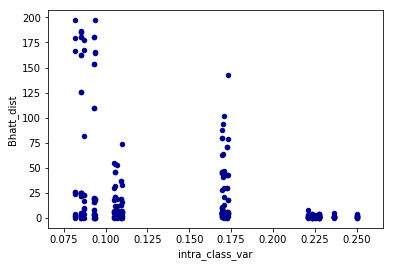

In [69]:
cond1=trial_df['intra_class_var']>0.0
cond2=trial_df['intra_class_var']<5

trl_df_filter=trial_df.loc[(cond1)&(cond2),:]
ax1 = trl_df_filter.plot.scatter(x='intra_class_var',y='Bhatt_dist',c='DarkBlue')

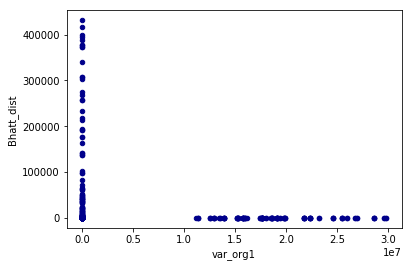

In [189]:
ax1 = trial_df.plot.scatter(x='var_org1',
...                       y='Bhatt_dist',
...                       c='DarkBlue')

## Distance metric analysis between organs using aggregation of per organ texture data across multiple image slices

In [386]:
#Setting file types and grounds. 
file_set_keys=[x for x in list(file_dict.keys()) if x.find('_texture images')!=-1]
ground_set_keys=[x for x in list(file_dict.keys()) if x.find('_ground')!=-1]
roi_set_keys=[x for x in list(file_dict.keys()) if x.find('mask_roi')!=-1]

In [464]:
#Setting variables and parameters
file_type=['t2spir','t1dual']#,

windows=['win_5','win_3','win_11','win_9','win_7']
#Org information
distances = (1,2,3)#,3
theta = (0, np.pi/4, np.pi/2, 3*np.pi/4)
props = ('contrast', 'homogeneity','dissimilarity','energy','correlation','ASM')
hist_dst=r'\\nsq024vs\u8\aczd087\MyDocs\My Pictures\Thesis results\Distance metrics evaluation\histograms'

In [490]:
data_bs=[]

In [495]:

#Iterating through the windows
for wind in windows:
    
    i=-1
    #Iterating through to different distances, angles and properties. 
    for no1,dist in enumerate(distances):

        for no2,angle in enumerate(theta):

            for no3,properties in enumerate(props):
                
                i+=1
                final_file_list=[]
                for file_keys in file_set_keys:
                    #ipdb.set_trace()
                    #Getting image type iterating through and getting image types 
                    det_img_type=[x for x in file_type if x in file_keys.lower()]
                    
                    if len(det_img_type)>0:
                        
                        #Getting ground key for associated file type. 
                        grnd_dict_key=[x for x in ground_set_keys if x.find(det_img_type[0])!=-1]
                        roi_dict_key=[x for x in roi_set_keys if x.find(det_img_type[0])!=-1]
                        
                        #Getting ground file name substrings
                        grnd_f_basenames=get_file_name_only(file_dict[grnd_dict_key[0]])
                        roi_f_basenames=get_file_name_only(file_dict[roi_dict_key[0]])
                        
                        #Changing file name structure to suit outphase numbering
                        if file_keys.find('_outphase')!=-1:
                            file_grnd_dict=gen_grnd_dict_link(file_dict[grnd_dict_key[0]])
                        else:
                            file_grnd_dict=dict(zip(grnd_f_basenames,file_dict[grnd_dict_key[0]]))
                        
                        file_roi_dict=dict(zip(roi_f_basenames,file_dict[roi_dict_key[0]]))
                        
                        #Getting file locations of file types that match ground requirements
                        unfilt_file_list=file_dict[file_keys]
                        #Getting specific files given str conditions of window size and ground file name
                        filt_file_list=get_spec_file_set(unfilt_file_list,
                                                         [file_grnd_dict.keys(),[wind]])
                        #Generate tuple set of images for set based on file input
                        tmp_tuple_set=gen_mask_file_tuple_list(file_grnd_dict,
                                                               filt_file_list)
                        #Creating master dictionary
                        mast_arr_dict={'Background':np.array([]),'Liver':np.array([]),'r_kidney':np.array([]),
                                       'l_kidney':np.array([]),'spleen':np.array([])}
                        
                        #Getting specific file set that match substring requirements
                        for mask_f,file_f in tmp_tuple_set:
                            #Loading data into array for analysis
                            mask_f_arr=imageio.imread(mask_f)
                            file_f_arr=np.load(file_f,allow_pickle=True)
                            
                            #Getting ROI key
                            ROI_dict_key=[x for x in roi_f_basenames if file_f.find(x)!=-1]
                            roi_f_arr=imageio.imread(file_roi_dict[ROI_dict_key[0]])
                            
                            file_f_arr_spec=file_f_arr[:,:,i]
  
                            slic_var=np.var(file_f_arr_spec)
                            tmp_f_arr_dict=get_org_spec_text_img_region_raw_data(file_f_arr_spec,mask_f_arr,roi_f_arr)

                            mast_arr_dict=merge_org_to_org_dict(mast_arr_dict,tmp_f_arr_dict)
                        #ipdb.set_trace()
                        
                        sum_stat_dict={}
                        #Computer summary statistics on dataset
                        for orgs,org_arr in mast_arr_dict.items():
                            tmp_var=org_arr.var()
                            tmp_mean=org_arr.mean()
                            sum_stat_dict[orgs]=[tmp_mean,tmp_var]
                         
                        org_combos=list(itertools.combinations(list(sum_stat_dict.keys()),
                                                       2)) 
                        
                        #ipdb.set_trace()
                        mahal_chart_gen=None
                        euclid_chart_gen=None
                        dist_dict={}
                        for vals in org_combos:

                            tmp_bhat_dist,mahal_dist,eucl_dist=bhatt_dist_approx_stat_summary(sum_stat_dict[vals[0]],
                                                                         sum_stat_dict[vals[1]])
                            
                            wasser_dist=wasserstein_distance(sum_stat_dict[vals[0]],
                                                             sum_stat_dict[vals[1]])
                            
                            #Getting initial file name for analysis. 
                            
                        
                        #tmp_emd_dist=Wasserstein_dist(tmp_arr1_norm,tmp_arr2_norm)
                        #Appending information to new database
                            file_row=list(vals)+sum_stat_dict[vals[0]]+sum_stat_dict[vals[1]]+[file_keys,i,wind,dist,angle,properties,
                                                                                            tmp_bhat_dist,mahal_dist,eucl_dist,
                                                                                               slic_var,wasser_dist,file_f]
                            
                            data_bs.append(file_row)
                            key_name=vals[0]+'_to_'+vals[1]
                            dist_dict[key_name]=[mahal_dist,eucl_dist]
                        #Assessing final histograms if visualisations are necessary
                        #ipdb.set_trace()
                        for orgs,org_dist in dist_dict.items():
                            #Getting naming conventions setup
                            orgslist=orgs.split('_to_')
                            st_f_name=wind+'_dist_'+str(dist)+'angle'+str(round(angle,2))+'_prop_'+properties+file_keys
                            
                            if all(x<1 for x in org_dist)==True:
                                continue
                            elif (org_dist[0]>1.05) or (org_dist[1]>10):
                                f_f_name=orgs+'_euclid_dist_'+str(round(org_dist[1],2))+'_mahaldist_'+str(round(org_dist[0],2))+st_f_name+'.jpeg'
                                dst_fname=os.path.join(hist_dst,f_f_name)
                                #    #Generating /Writing histogram to file 
                                gen_hist_img_overlay(mast_arr_dict,dst_fname,orgslist)


Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice.
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary a

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array

Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary

Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary a

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary 

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary arr

Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array: r_kidney
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: l_kidney
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: spleen
Master key not present in temporary array: Liver
Master key not present in temporary array:

In [479]:
trl_list=[0,1,2]

any(x>1 for x in trl_list)

True

In [481]:
def gen_hist_img_overlay(mast_dict_file,hist_dst_path,org_cmp):
    
    """The purpose of this method is to determine overlay histogram for texture image regions."""
    fig, ax = plt.subplots(figsize=(15,15))
    for k,v in mast_dict_file.items():
        #Only plot items in the 
        if k in org_cmp:
            sns.distplot(v, ax=ax, kde=False,label=k)
    plt.legend(title='Organ', loc='upper right', labels=org_cmp,prop={'size': 12})
    
    plt.savefig(hist_dst_path)

In [501]:
trial_df=pd.DataFrame(data_bs,columns=['Organ1','Organ2','mean_org1','var_org1',
                                              'mean_org2','var_org2','file_type','file_slc_index','window_size','offset',
                                              'angle','property','Bhatt_dist','Mahal_dist','Euclid_dist','overall_var','wasser_dist','file_path'])
import re
trial_df['org_to_org']=trial_df["Organ1"].map(str) +'_to_'+ trial_df["Organ2"]
#trial_df['window_int'] = [''.join(re.findall("\d*\.?\d+", item)) for item in trial_df['window_size']]
#trial_df['window_int'] = pd.to_numeric(trial_df['window_int'])

trial_df.sort_values('Bhatt_dist',ascending=False).head()
#trial_df[~trial_df['window_size'].isin(['win_3','win_5'])].sort_values('Bhatt_dist',ascending=False)
trial_df.to_excel('pat1_all_text_img_tytpes_bhatt_dist_04_Oct_19.xlsx')

In [502]:
pwd

'F:\\Biomedical images\\Train\\MR\\1'

In [ ]:
cond1=trial_df['Euclid_dist']>200
cond2=
cond3=
trial_df[]

In [132]:
mahal_sorted=trial_df[(trial_df['overall_var']>1.1)&(trial_df['window_size']!='win_11')].sort_values('Mahal_dist',ascending=False)
mahal_sorted.head()

,Organ1,Organ2,mean_org1,var_org1,mean_org2,var_org2,file_slc_index,window_size,offset,angle,property,Bhatt_dist,Mahal_dist,Euclid_dist,overall_var,file_path,org_to_org,window_int
2706,Liver,spleen,2.831599,16.743581,3.748472,1.330433,54,win_9,3,0.785398,contrast,0.923573,0.922828,0.000745,5.673041,F:\Biomedical images\Train\MR\1\texture images...,Liver_to_spleen,9
2766,Liver,spleen,2.831599,16.743581,3.748472,1.330433,60,win_9,3,1.570796,contrast,0.923573,0.922828,0.000745,5.673041,F:\Biomedical images\Train\MR\1\texture images...,Liver_to_spleen,9
126,Liver,spleen,1.092444,4.593954,1.171181,0.377862,12,win_5,1,1.570796,contrast,0.905854,0.905781,0.000073,1.392290,F:\Biomedical images\Train\MR\1\texture images...,Liver_to_spleen,5
66,Liver,spleen,1.092444,4.593954,1.171181,0.377862,6,win_5,1,0.785398,contrast,0.905854,0.905781,0.000073,1.392290,F:\Biomedical images\Train\MR\1\texture images...,Liver_to_spleen,5
2466,Liver,spleen,2.083605,7.856740,2.560955,0.697208,30,win_9,2,0.785398,contrast,0.869286,0.868370,0.000916,2.935679,F:\Biomedical images\Train\MR\1\texture images...,Liver_to_spleen,9


In [425]:
trial_df.shape

(11610, 19)

In [424]:
trial_df[trial_df['file_path'].str.contains('T2SPIR')].shape

(3870, 19)

In [426]:
trial_df[trial_df['file_path'].str.contains('inphase')].shape

(3870, 19)

In [427]:
trial_df[trial_df['file_path'].str.contains('outphase')].shape

(3870, 19)

In [422]:
trial_df['file_path'].find('T2SPIR')

AttributeError: 'Series' object has no attribute 'find'

In [ ]:
mahal_sorted=trial_df.sort_values('Mahal_dist',ascending=False)

In [ ]:
Euclid_sorted=trial_df[trial_df['overall_var']>0.4].sort_values('Euclid_dist',ascending=False)
Euclid_sorted.head()

In [143]:


wasserstein_distance([0, 1, 3], [5, 6, 8,9,19])

8.066666666666666

In [138]:
trial_df['max_var_ratio']=(trial_df['var_org1']+trial_df['var_org2'])/trial_df[['var_org1','var_org2']].min(axis=1)


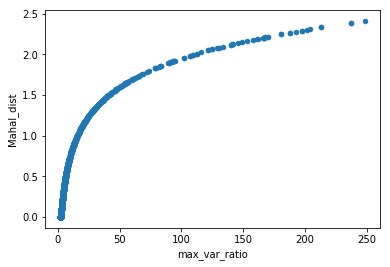

In [140]:
trial_df.plot.scatter('max_var_ratio','Mahal_dist')

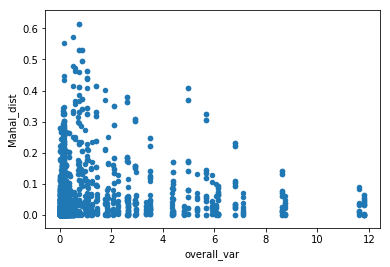

In [499]:
trial_df[trial_df['file_type']=='t2spir_texture images'].plot.scatter('overall_var','Mahal_dist')#[trial_df['overall_var']>0.5]

In [ ]:
trial_df.plot.scatter('overall_var','Mahal_dist')

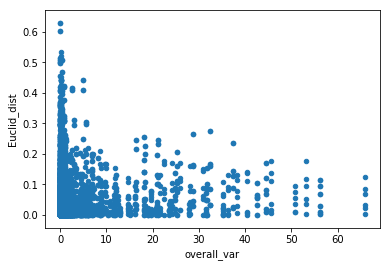

In [498]:
trial_df.plot.scatter('overall_var','Euclid_dist')

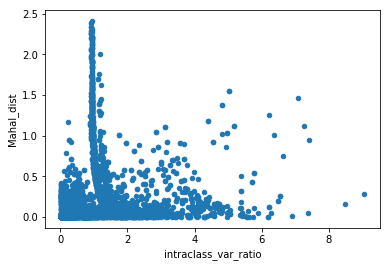

In [134]:
trial_df.plot.scatter('intraclass_var_ratio','Mahal_dist')

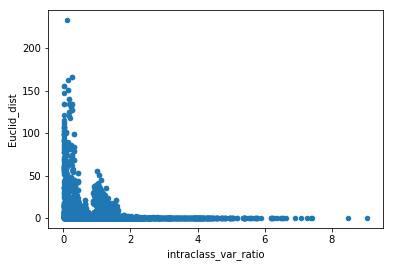

In [135]:
trial_df.plot.scatter('intraclass_var_ratio','Euclid_dist')

In [85]:
top_5=mahal_sorted['file_path'][:5]

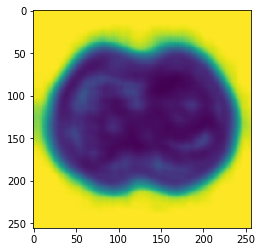

In [91]:
trl_img=np.load(top_5.iloc[0])
plt.imshow(trl_img[:,:,71])

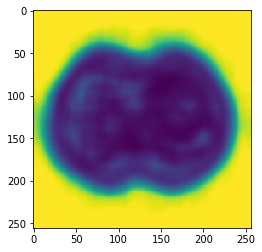

In [92]:
trl_img=np.load(top_5.iloc[1])
plt.imshow(trl_img[:,:,65])

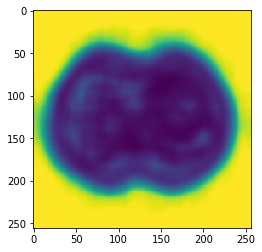

In [93]:
trl_img=np.load(top_5.iloc[2])
plt.imshow(trl_img[:,:,59])

In [213]:
trial_df.to_excel('pat_1_t2spir_slc_19_26_wind_5_to_11_bhatt_dist_wrt_ofs_angle_prop_01Oct19.xlsx')

In [10]:
trial_df=pd.read_excel('pat_1_t2spir_slc_19_26_wind_5_to_11_bhatt_dist_wrt_ofs_angle_prop_01Oct19.xlsx')

### Visualisation of org to org aggregated dataframe results

#### Original dataset image analysis

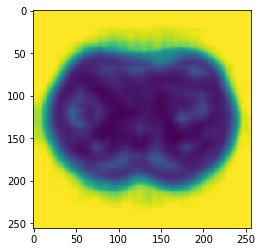

In [35]:
trl_arr=np.load('text_img_pat_id_1_win_11_16lvl_IMG-0002-00021_t2spir_dicom_anon_grey_levels.npy')

plt.imshow(trl_arr[:,:,5])
plt.savefig('low_variance_texture_img_lvl_16_IMG-0002-00021_wind_11_ASM.png')

#### Wasserstein distance

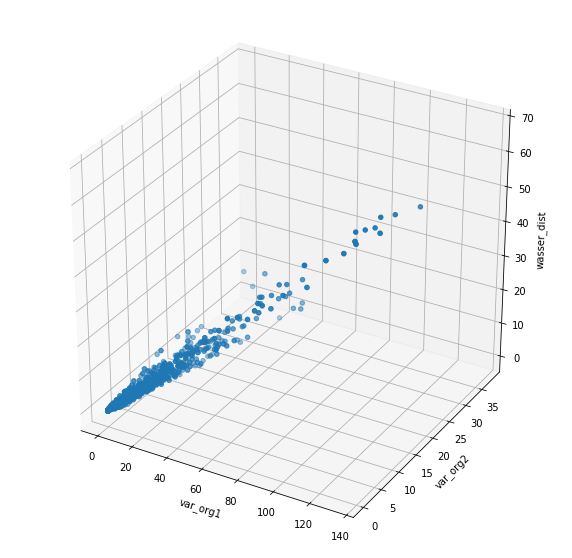

In [412]:


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = trial_df['var_org1']
ys = trial_df['var_org2']
zs = trial_df['wasser_dist']
ax.scatter(xs, ys, zs)

ax.set_xlabel('var_org1')
ax.set_ylabel('var_org2')
ax.set_zlabel('wasser_dist')

#plt.savefig('t2spir_pat_1_img_19_wi_greylvlset_16_3dscatter_bhatt_dist_vs_org1var_vs_org2_var.png')

plt.show()


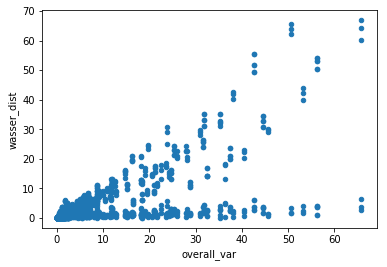

In [413]:
trial_df.plot.scatter('overall_var','wasser_dist')

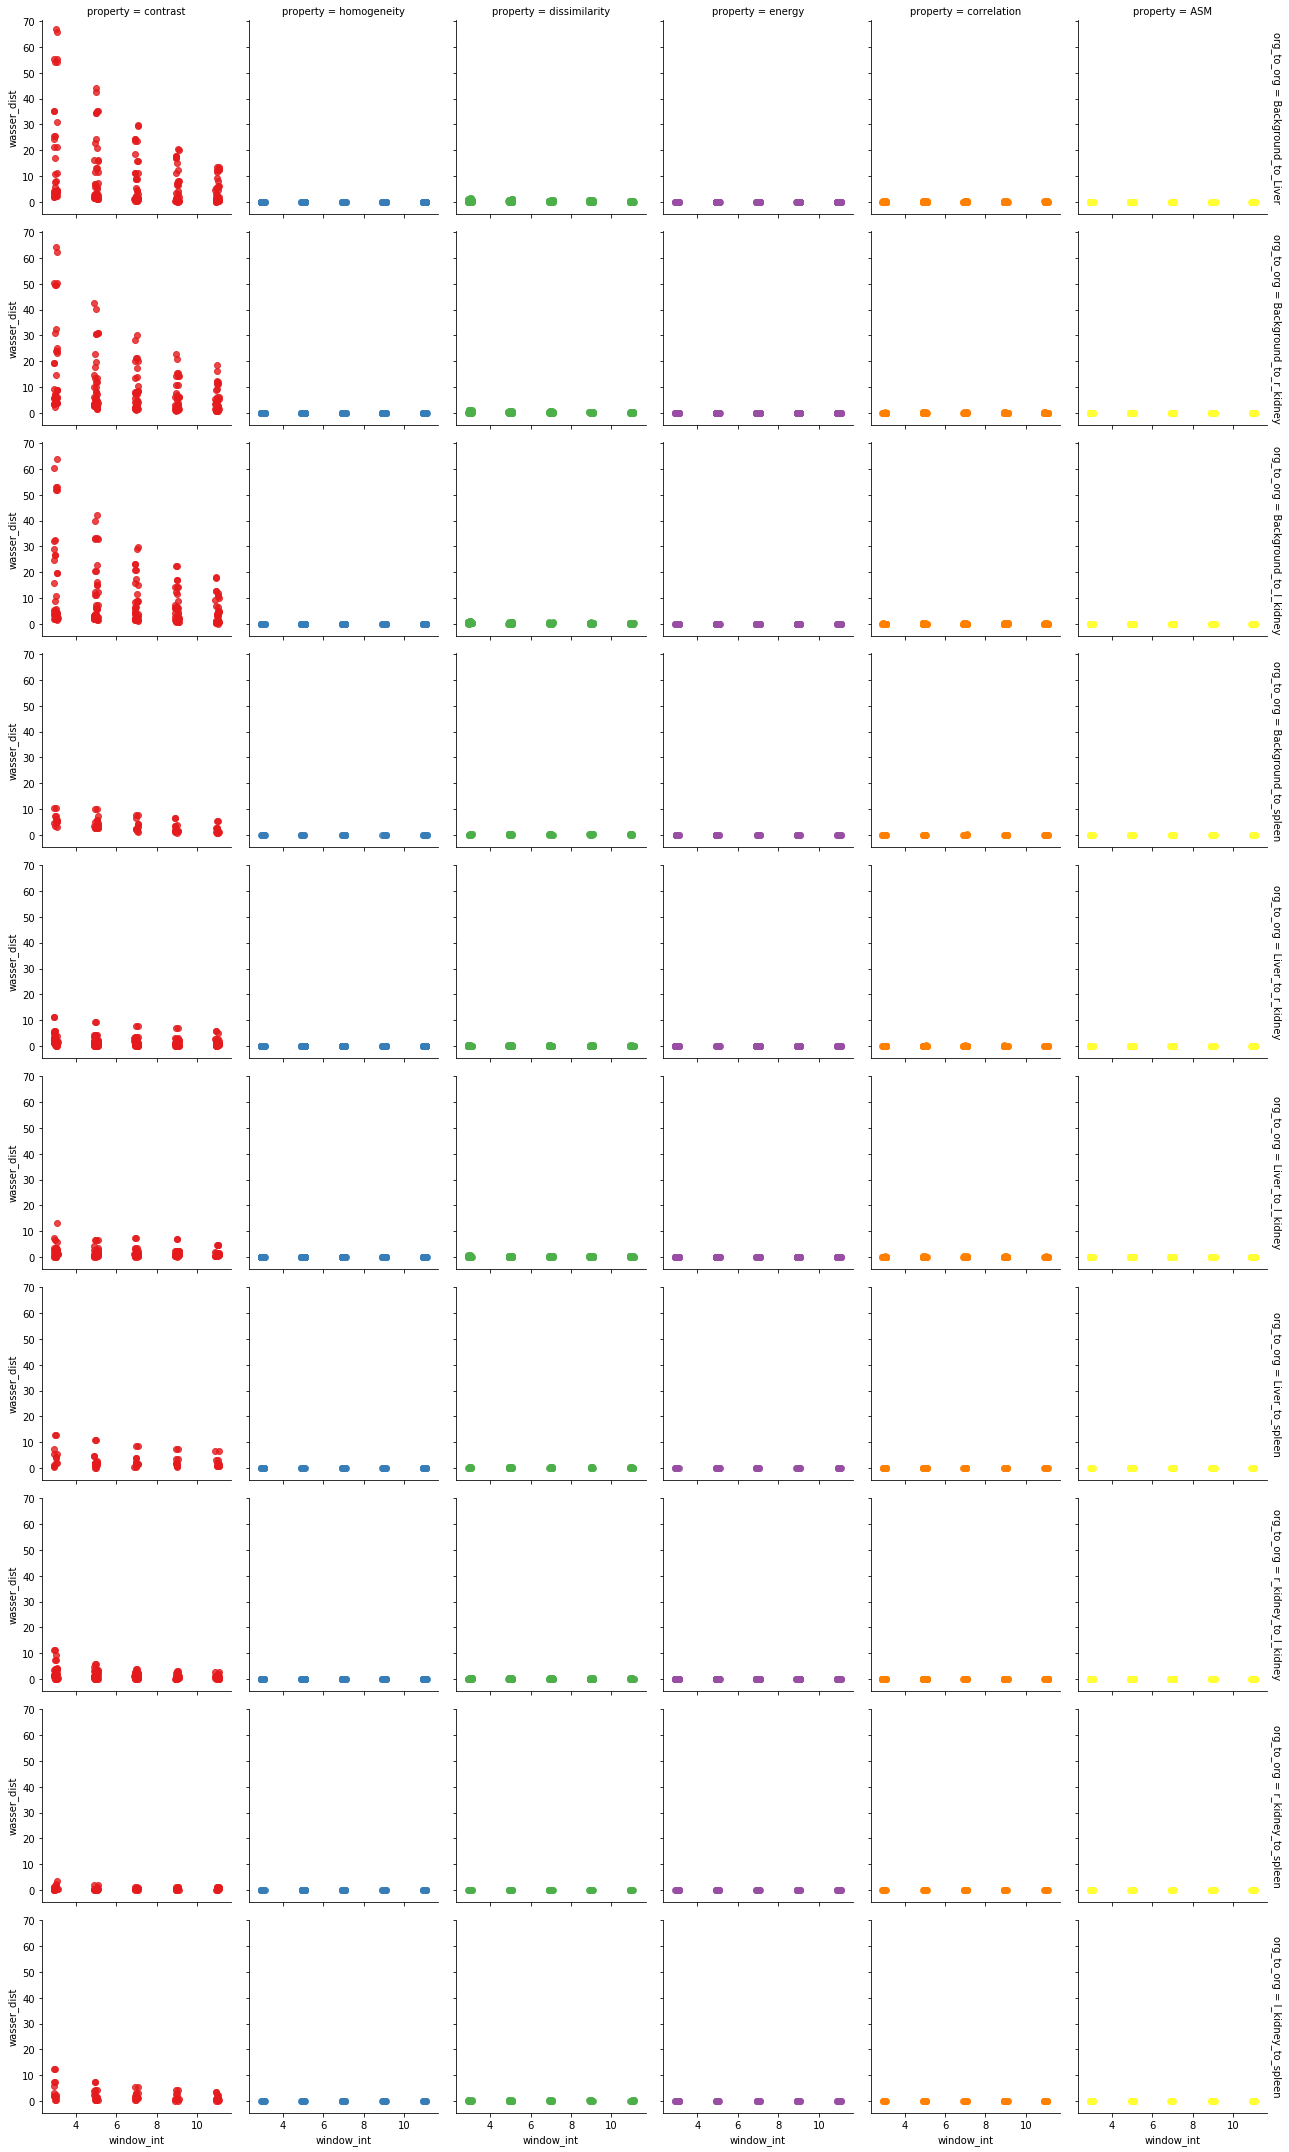

In [414]:
g = sns.FacetGrid(trial_df, row='org_to_org', col='property',hue='property', palette='Set1', margin_titles=True)
g.map(sns.regplot,'window_int','wasser_dist', fit_reg=False, x_jitter=.1)
plt.savefig('facet_plot_window_size_org_prop_wasserstein_dist.jpeg', dpi=900)

#### Mahalnobis results

In [429]:
t2spir_df=trial_df[trial_df['file_path'].str.contains('T2SPIR')]

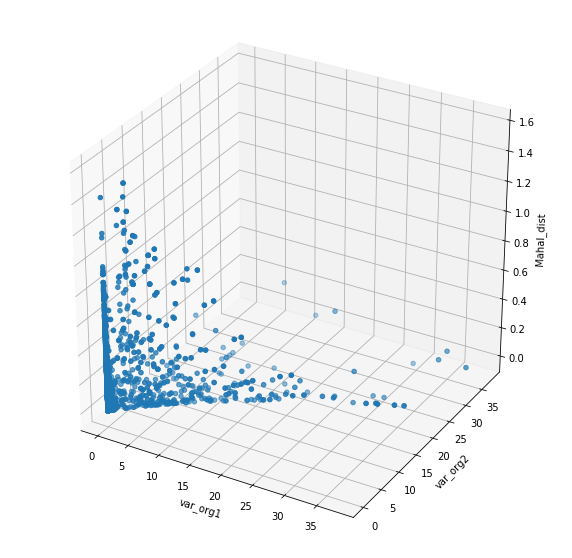

In [430]:


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = t2spir_df['var_org1']
ys = t2spir_df['var_org2']
zs = t2spir_df['Mahal_dist']
ax.scatter(xs, ys, zs)

ax.set_xlabel('var_org1')
ax.set_ylabel('var_org2')
ax.set_zlabel('Mahal_dist')

#plt.savefig('t2spir_pat_1_img_19_wi_greylvlset_16_3dscatter_bhatt_dist_vs_org1var_vs_org2_var.png')

plt.show()


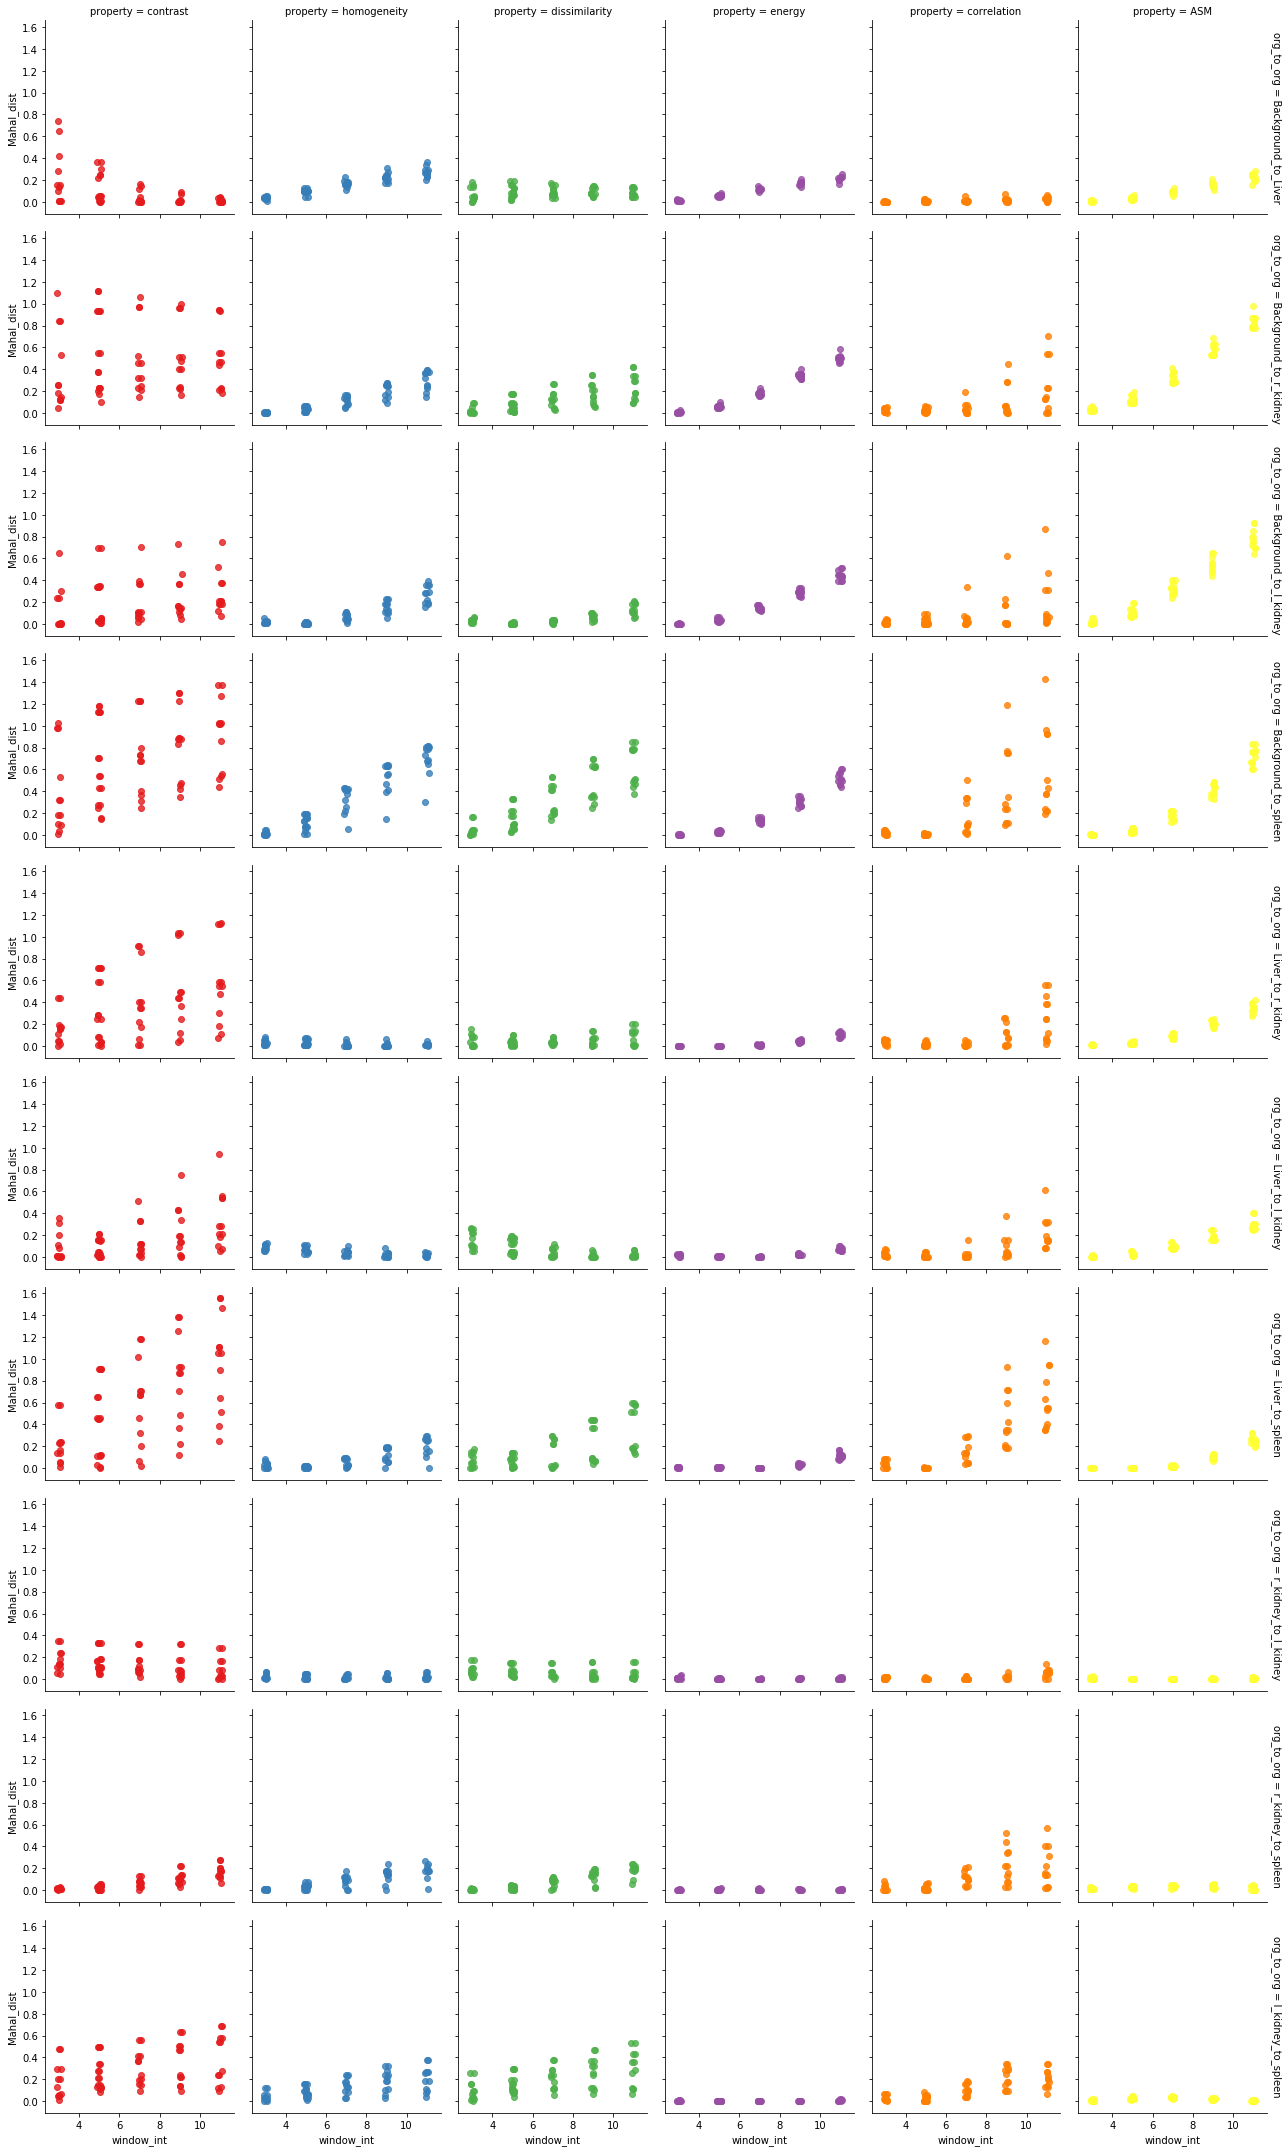

In [431]:
#plt.figure(figsize=(20,))
g = sns.FacetGrid(t2spir_df, row='org_to_org', col='property',hue='property', palette='Set1', margin_titles=True)
g.map(sns.regplot,'window_int','Mahal_dist', fit_reg=False, x_jitter=.1)
#plt.savefig('facet_plot_window_size_org_prop_mahalonobis_dist.jpeg', dpi=900)

### Euclidean distance metrics analysis

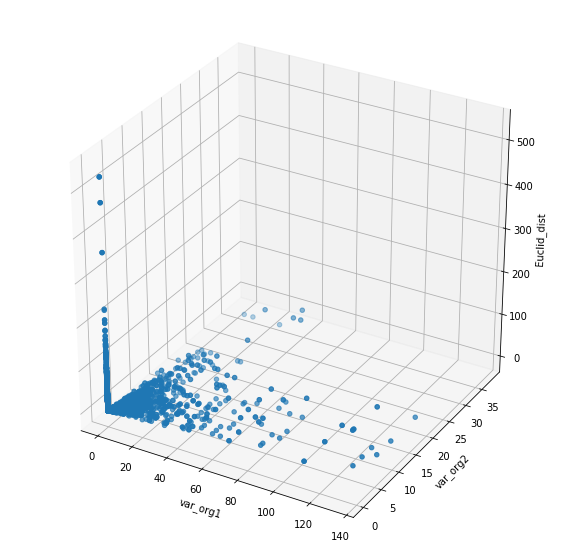

In [418]:


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = trial_df['var_org1']
ys = trial_df['var_org2']
zs = trial_df['Euclid_dist']
ax.scatter(xs, ys, zs)

ax.set_xlabel('var_org1')
ax.set_ylabel('var_org2')
ax.set_zlabel('Euclid_dist')

#plt.savefig('t2spir_pat_1_img_19_wi_greylvlset_16_3dscatter_bhatt_dist_vs_org1var_vs_org2_var.png')

plt.show()


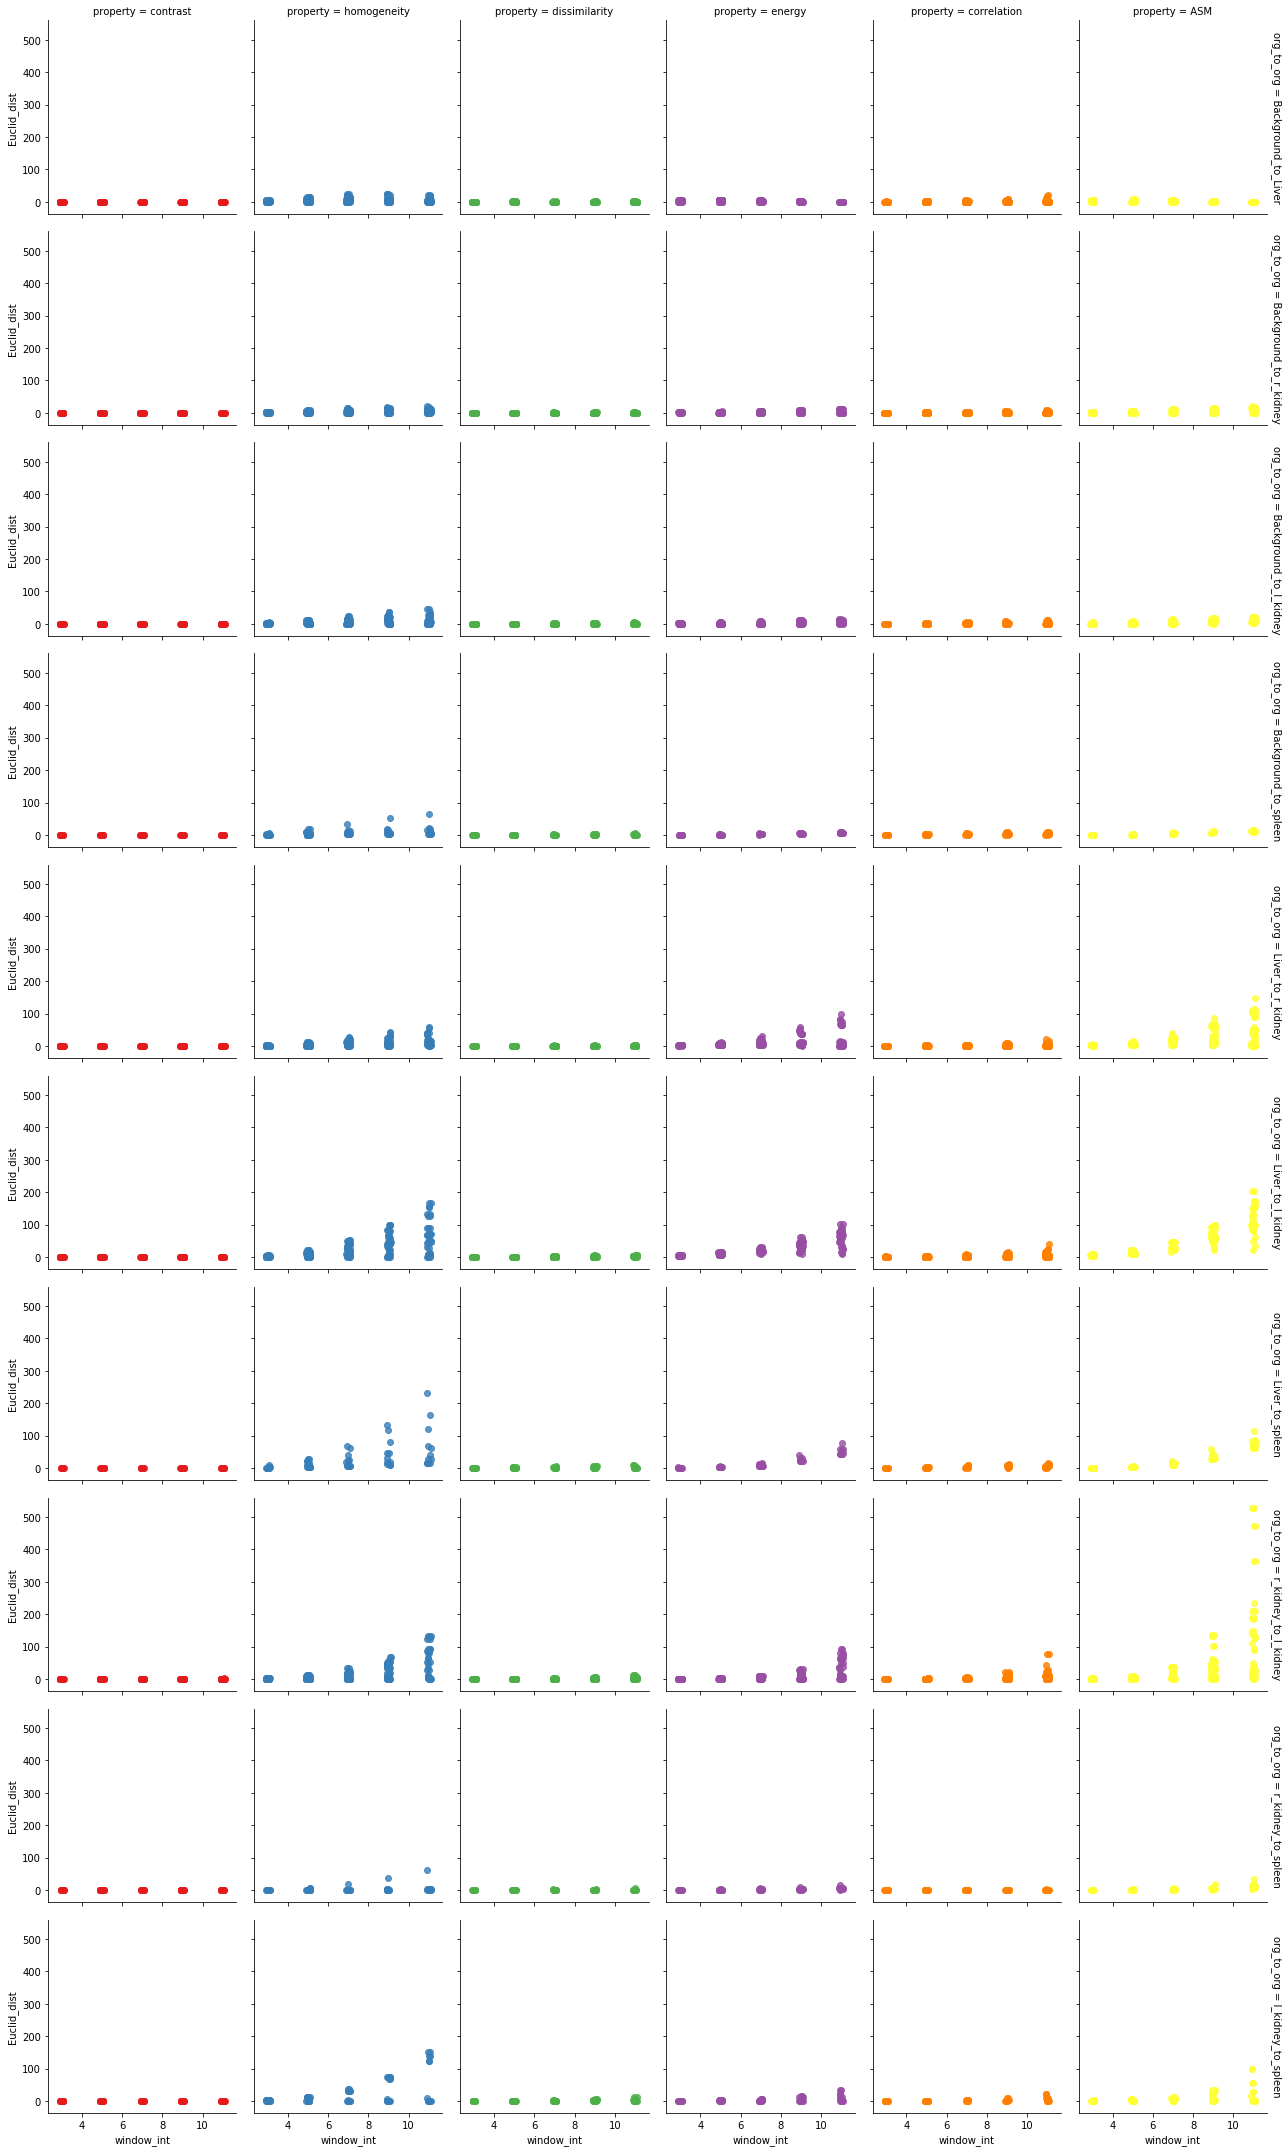

In [419]:
g = sns.FacetGrid(trial_df, row='org_to_org', col='property',hue='property', palette='Set1', margin_titles=True)
g.map(sns.regplot,'window_int','Euclid_dist', fit_reg=False, x_jitter=.1)
#plt.savefig('facet_plot_window_size_org_prop_euclidean_dist.jpeg', dpi=900)

In [18]:
trial_df['window_int'].dtype

dtype('int64')

#### Actual Bhattacharya distance resullts

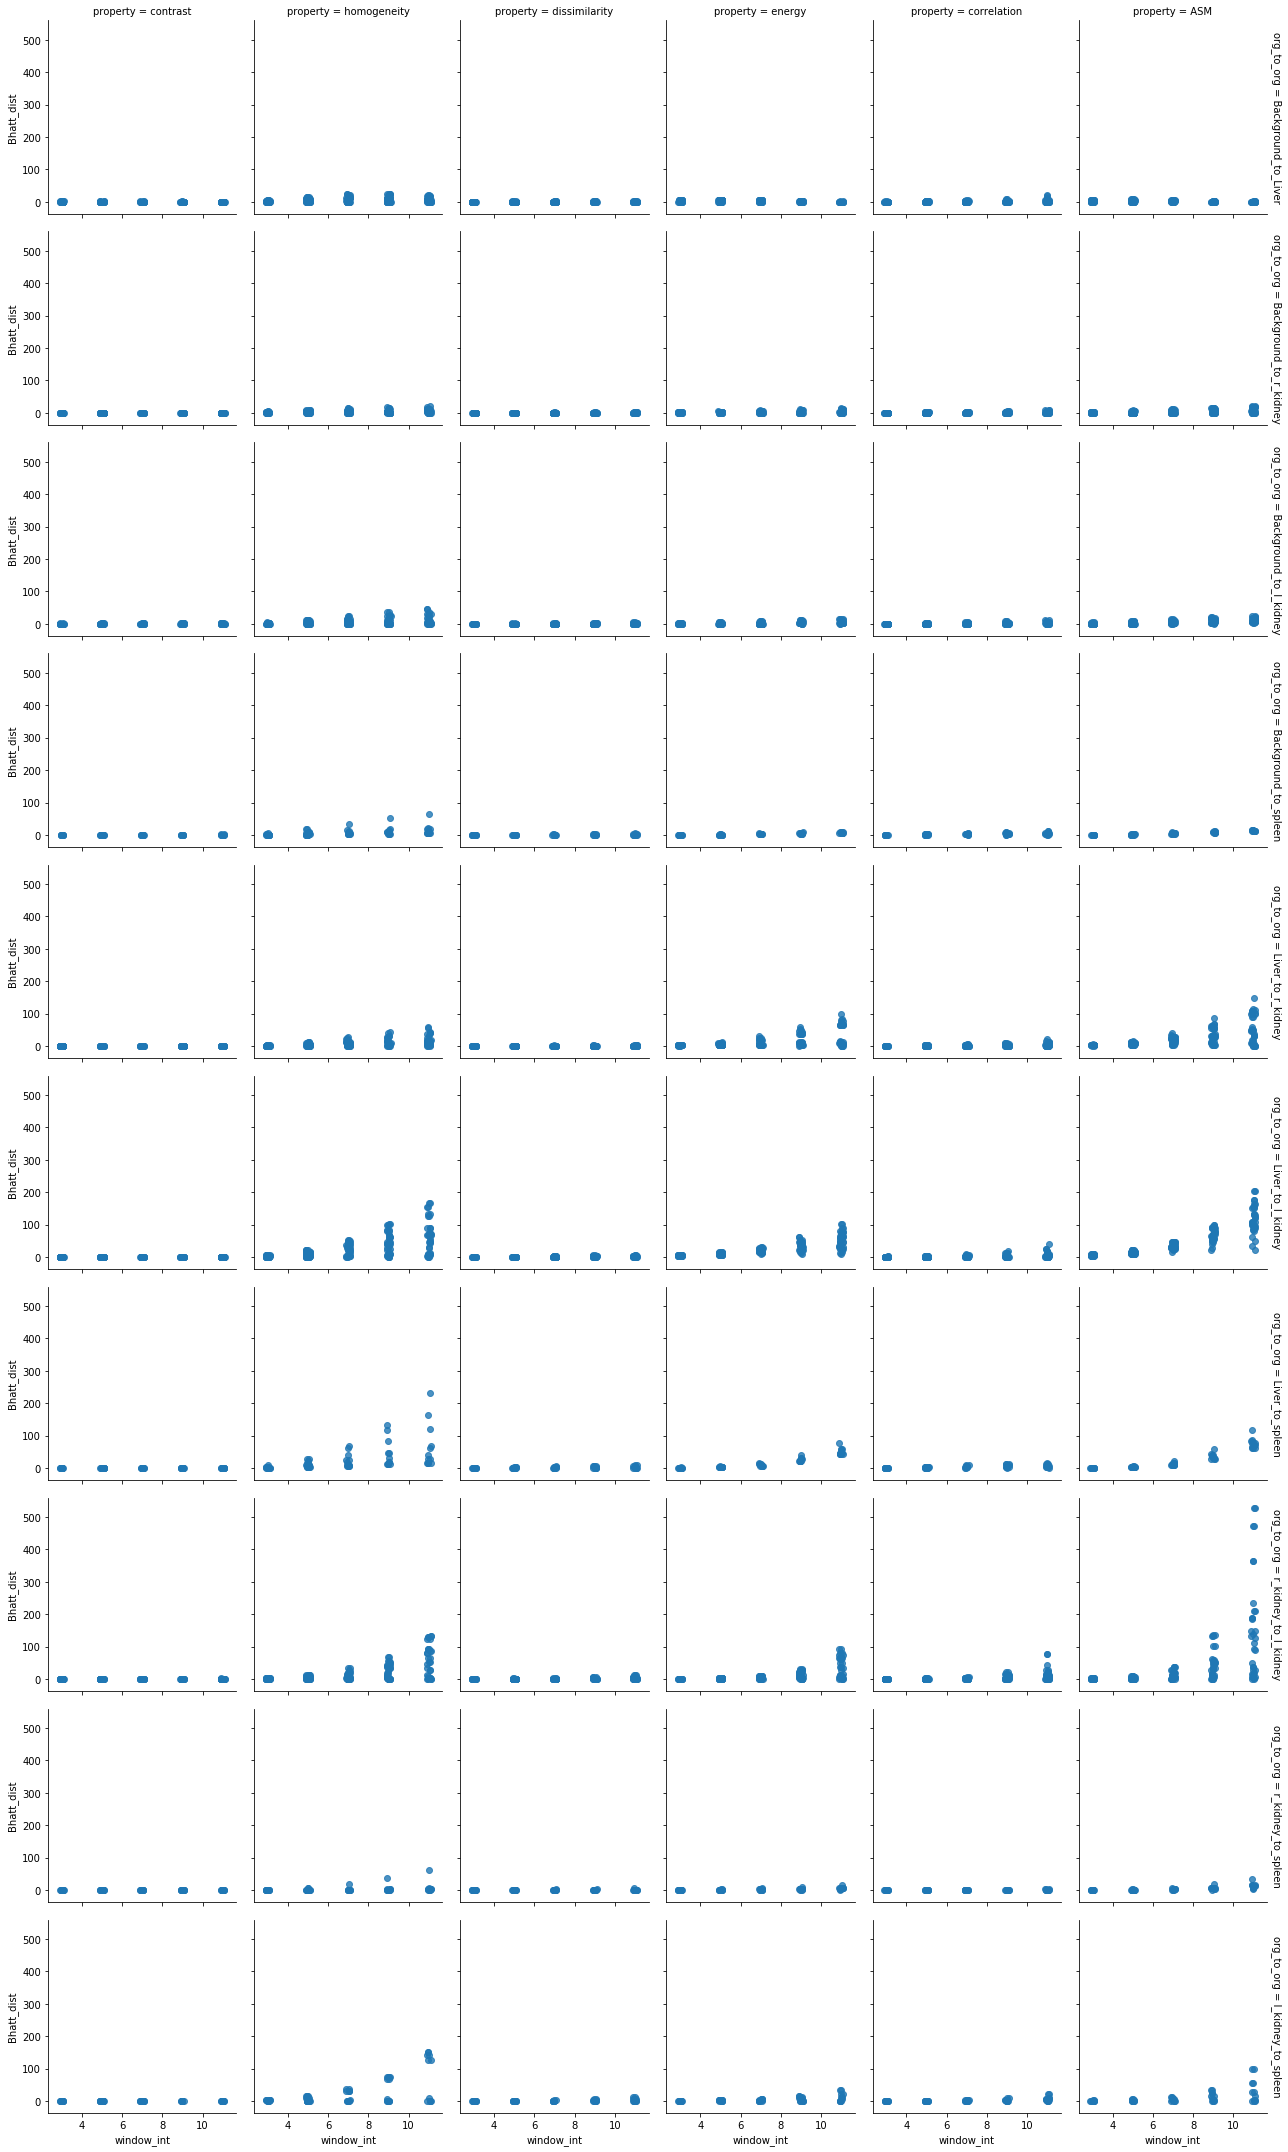

In [420]:
#plt.figure(figsize=(20,))
g = sns.FacetGrid(trial_df, row='org_to_org', col='property', margin_titles=True)
g.map(sns.regplot,'window_int','Bhatt_dist', fit_reg=False, x_jitter=.1)
#plt.savefig('facet_plot_window_size_org_prop_bhatt_dist.jpeg', dpi=900)

[Text(0,0,'contrast'),
 Text(0,0,'homogeneity'),
 Text(0,0,'dissimilarity'),
 Text(0,0,'energy'),
 Text(0,0,'correlation'),
 Text(0,0,'ASM')]

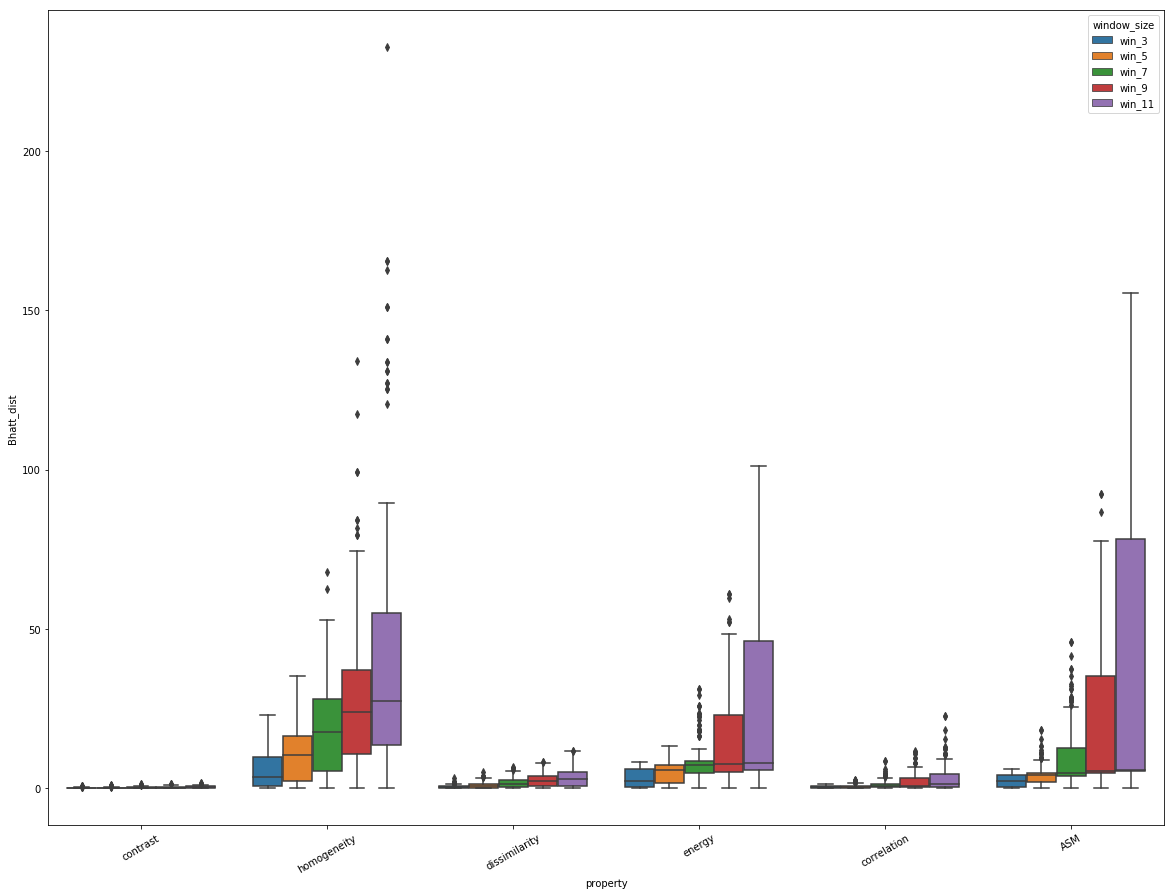

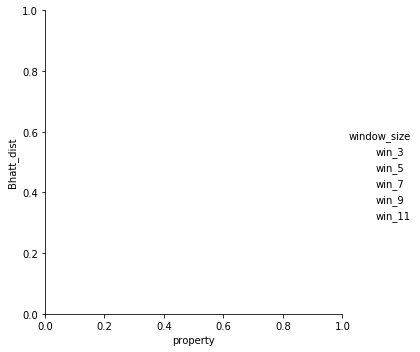

In [211]:

fig, ax1 = plt.subplots(figsize=(20,15))
sns.catplot(ax=ax1,x='property',y='Bhatt_dist',hue='window_size',kind='box',data=trial_df)#,hue='property'

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)